# 시계열 예측

- 시계열 값의 미래 예측 (time series forecasting)
 - 수요예측, 매출예측, 생산/물류/재고 예측, 리스크/장애/이상 예측 등
 
## 접근법
### 시계열 모델
- 자신의 과거 값만 사용하여 미래 값을 예측하는 방법
 - 선형예측, ARIMA, Prophet 등 수리 모델 기반의 단변수 예측 모델이 널리 사용되었다
 - 신호의 패턴에 따라 성능에 한계가 있다
 - 랜덤한 성분은 예측이 안된다 (트렌드, 주기성 만 예측 가능)
- 선형 회귀 (linear regression) 모델: 자신의 과거 샘플의 가중합으로 미래를 예측하는 모델


 > $\hat{y_{n}} = b +a_{1}y_{n-1} + a_{2}y_{n-2} + a_{3}y_{n-3} + ...$
 
 - ARIMA 모델: 선형 모델을 개선하여, 계절성, 트렌드, 시변성 등을 반영한 모델
 - 결측치가 없어야 한다 (결측치가 있으면 계산 오류 발생)
 - 단변수 시계열 예측 도구로 Prophet이 유용하다
 - 시계열 데이터로 보고 선형예측
 - split_seq, walk_forward 모델
 - 데이터의 순서 정보를 사용
- Prophet으로 예측

 
### X-y 모델
- 다양한 관련 외부 신호들을 보고 예측하는 X-y 모델
 - 입력 X에 y의 과거 값들도 포함시킬 수 있다
 - 입력 X에 변형된 신호들을 포함시킬 수 있다 (이동 평균 등)
 - 다양한 종류의 빅데이터를 사용하면 성능이 개선된다
 - 카테고리 변수들을 다루기에 X-y 모델이 유리하다 (선형계열 모델은 카테고리 변수를 표현하는데 한계가 있다)
- 랜덤 포레스트, 부스팅 등 머신러닝 모델이 널리 사용된다.
 - 복잡한 현상을 모델링하기 위해 딥러닝 모델 (MLP, CNN, LSTM 등)을 사용하기도 한다
 

## 특성 추가
- 평균, 분산, 최대치, 피크치 등을 추가하는 방법

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6,4)
matplotlib.rcParams.update({'font.size': 13})

(108, 2)


,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


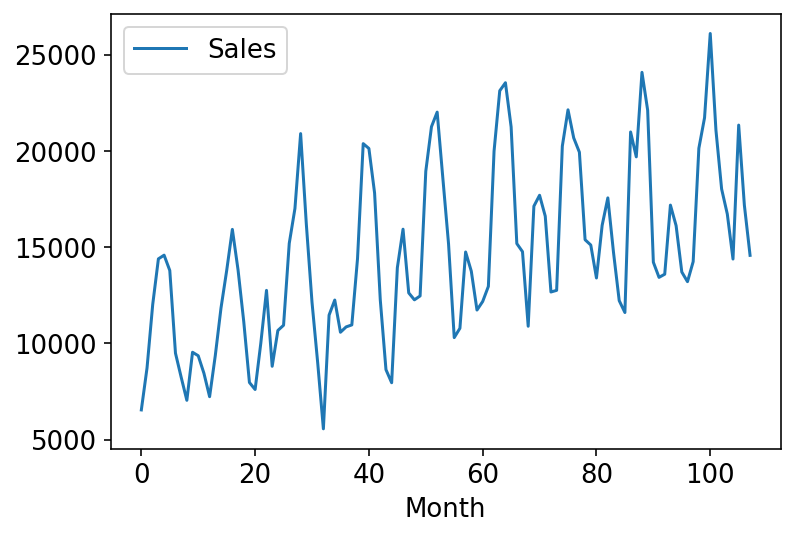

In [66]:
## 자동차 판매 데이터 읽기

# data = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/car_sales.csv")
data = pd.read_csv("car_sales.csv")
print(data.shape)

data.plot()
plt.xlabel('Month')

data[:5]

## walk forward 예측
- 내일이 되면 내일 기온을 알 수 있으므로 모레 기온을 예측하는데 내일 데이터를 사용할 수 있다
- 이렇게 미래로 하나씩 이동하면서 데이터를 이용하는 예측을 walk forward 예측이라고 한다
- 시계열 데이터를 테이블 구조로 만들기
 - 시계열 예측에 머신러닝 모델을 쉽게 적용하기 위해서 비정형인 시계열 데이터를 정형 데이터인 테이블 구조로 만들어야 한다
 - 아래는 5개의 시계열 데이터를 보고 6번째 값을 예측하는 경우이며 walk forward 예측을 위한 테이블을 보였다


<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-08%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%203.44.24.png?raw=1" width=600 aligh='left'>

In [13]:
## walk forward 예측을 위한 데이터 생성

def split_seq(sequence, n_steps):
    x, y = [], []
    for i in range(len(sequence)):
        if i > len(sequence) - (n_steps + 1) : break
        x.append(sequence[i:i+n_steps])
        y.append(sequence[i+n_steps])
    return np.array(x), np.array(y)

sequence = [1,2,3,4,5,6,7,8,9,10,11,12,13]
X, y = split_seq(sequence, 5)
X, y

(array([[ 1,  2,  3,  4,  5],
        [ 2,  3,  4,  5,  6],
        [ 3,  4,  5,  6,  7],
        [ 4,  5,  6,  7,  8],
        [ 5,  6,  7,  8,  9],
        [ 6,  7,  8,  9, 10],
        [ 7,  8,  9, 10, 11],
        [ 8,  9, 10, 11, 12]]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13]))

In [21]:
## 회귀 분석의 성능 지표 보기

def show_reg_result(y_test,y_pred):
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(3))

## 순서를 유지하기 위해서
- shuffle=False

In [67]:
## 과거 12개월 데이터를 사용한 매출 예측

# X와 y를 만든후 훈련, 검증 데이터 나누기
X, y = split_seq(sale,12)
X_train, X_test, y_train, y_test = train_test_split(X,y,
                shuffle=False, random_state=7)

print(len(X_train), len(X_test))

# 모델 학습과 예측 수행
lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test)

# 회귀 성능 보기
show_reg_result(y_test,y_pred)

72 24
Max Error:  3630.144
Mean Absolute Error:  1471.986
Root Mean Squared Error:  1791.788
R-Squared:  0.796


## 회귀 모델 성능 평가
- 회귀 모델의 성능을 평가하는 척도로 기본적으로 R-Squared를 사용하며 MAE, RMSE 등을 참고로 본다
 - MAE: mean absolute error  
 - MSE: mean squared error    
 - RMSE: root MSE  

$MAE = $$1\over{N}$$ \sum |y_{i} - \hat{y}|$

$MSE = $$1\over{N}$$ \sum (y_{i} - \hat{y})^{2}$

$RMSE = \sqrt{MSE}$

$R^{2} = 1$-$\sum(y_{i}-\hat{y})^{2}\over{\sum(y_{i}-\bar{y})^{2}}$ $= 1$-$MSE\over{Variance}$  
 >  $y$ :  실제값  
 >  $\hat{y}$ :  예측치  
 >  $\bar{y}$ :  평균치
 
 ### R-Squared
- 회귀 성능의 기본적인 평가 지표
- MSE를 분산으로 정규화한 값을 사용한다
- R-sqaured 값은 1에 가까울수록 완벽한 예측을 수행한 것이고, 0 근처이면 오차 평균치가 표준편차 정도인 경우이다

In [20]:
def plot_reg_result(y_test, y_pred, N=50):
    y_test=y_test.ravel()
    y_pred=y_pred.ravel()
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_test, y_test - y_pred, s=5)

In [26]:
# plot_reg_result(y_test, y_pred, N=50)

## 랜덤 포레스트 모델

In [23]:
# rfr = RandomForestRegressor()
# rfr.fit(X_train, y_train)
# rfr.score(X_test, y_test)

0.7527350700481306

In [52]:
df = data.copy()
df['3-max'] = df['Sales'].rolling(3, min_periods=1).max()
df['6-mean'] = df['Sales'].rolling(6, min_periods=1).mean()
df['7-std'] = df['Sales'].rolling(8, min_periods=1).std().fillna(0)
df[:8]

,Month,Sales,3-max,6-mean,7-std
0,1960-01,6550,6550.0,6550.000000,0.000000
1,1960-02,8728,8728.0,7639.000000,1540.078569
2,1960-03,12026,12026.0,9101.333333,2757.023274
3,1960-04,14395,14395.0,10424.750000,3474.647932
4,1960-05,14587,14587.0,11257.200000,3538.325692
5,1960-06,13791,14587.0,11679.500000,3329.537911
6,1960-07,9498,14587.0,12170.833333,3149.291107
7,1960-08,8251,13791.0,12091.333333,3116.973246


<AxesSubplot:>

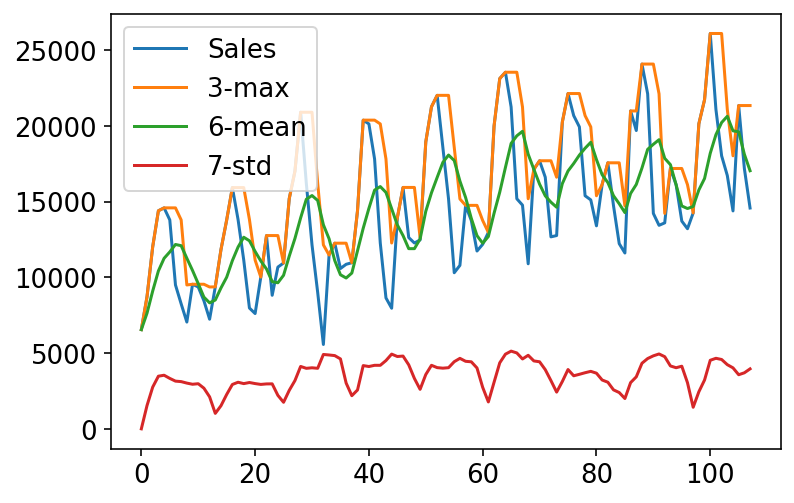

In [53]:
df.plot()

# 피크 값 및 빈도수 찾기

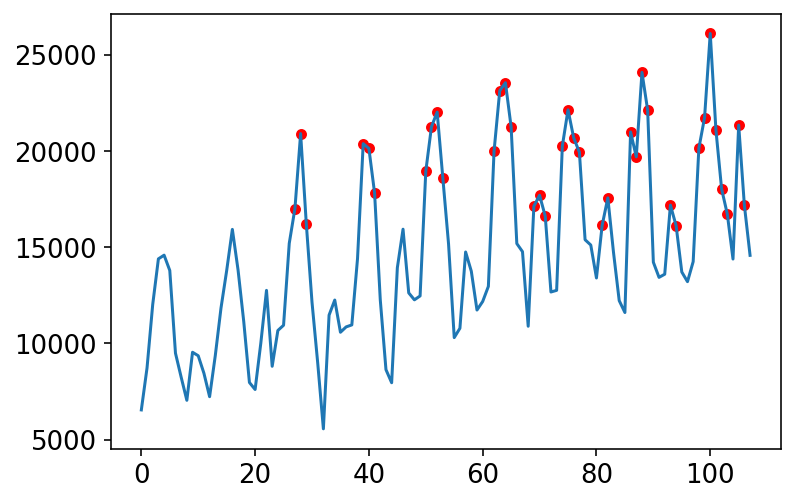

In [54]:
df['peak-16'] = df['Sales'][df['Sales'] > 16000]
plt.plot(df.Sales)
plt.scatter(range(len(df)), df['peak-16'],c='r', s=20)

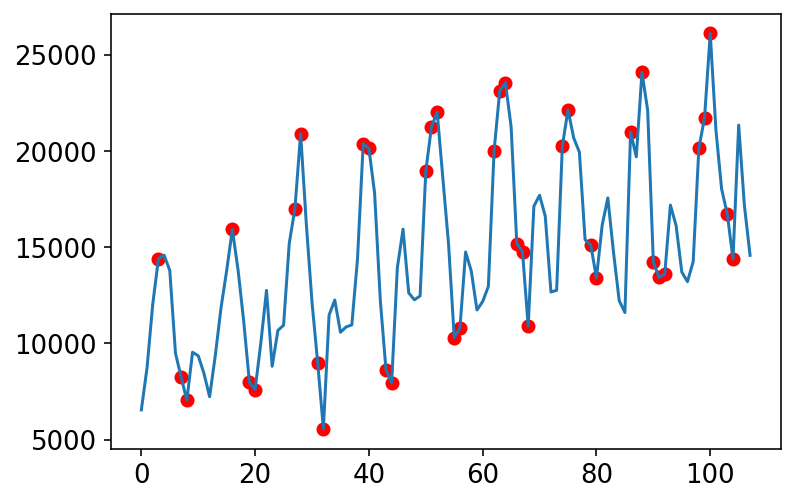

In [55]:
df['peak-average'] = df['Sales'][np.abs(df['Sales']-df['6-mean']) > 3800]
plt.plot(df.Sales)
plt.scatter(range(len(df)), df['peak-average'],c='r')

## 일정 구간 동안 피크의 수를 센다

Text(0.5, 0, 'Month')

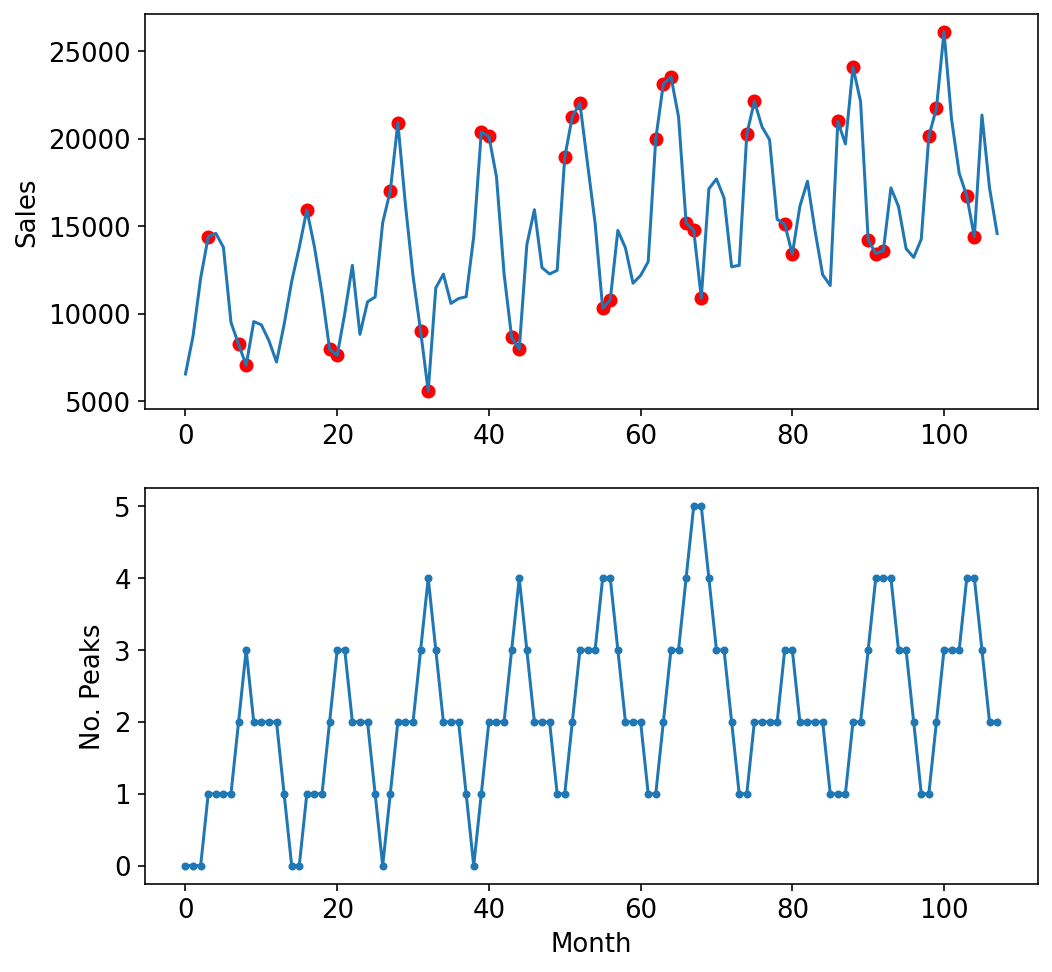

In [56]:
df['peak-count-6'] = df['peak-average'].rolling(6, min_periods=1).count()

f,(ax1, ax2) = plt.subplots(2, figsize=(8,8))
ax1.plot(df['Sales'])
ax1.scatter(range(len(df)), df['peak-average'],c='r')
ax2.plot(df['peak-count-6'], marker='.')
ax1.set_ylabel("Sales")
ax2.set_ylabel("No. Peaks")
ax2.set_xlabel("Month")

In [57]:
df.drop(['Month','Sales','peak-16', 'peak-average'],axis=1, inplace=True)
df

,3-max,6-mean,7-std,peak-count-6
0,6550.0,6550.000000,0.000000,0.0
1,8728.0,7639.000000,1540.078569,0.0
2,12026.0,9101.333333,2757.023274,0.0
3,14395.0,10424.750000,3474.647932,1.0
4,14587.0,11257.200000,3538.325692,1.0
...,...,...,...,...
103,21084.0,20632.166667,4236.089833,4.0
104,18024.0,19673.166667,4025.488149,4.0
105,21342.0,19609.333333,3572.075267,3.0
106,21342.0,18122.833333,3699.451521,2.0


## 선형 예측에 사용했던 테이블

In [58]:
df_X = pd.DataFrame(X)
print(df_X.shape)
df_X[:3]

(96, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,6550,8728,12026,14395,14587,13791,9498,8251,7049,9545,9364,8456
1,8728,12026,14395,14587,13791,9498,8251,7049,9545,9364,8456,7237
2,12026,14395,14587,13791,9498,8251,7049,9545,9364,8456,7237,9374


In [59]:
df_X.shape, df.shape

((96, 12), (108, 4))

In [60]:
df_history = df.copy()

In [61]:
# 하루 전까지의 데이터를 사용해야 한다. 오늘 데이터를 오늘 예측에 사용하면 안된다 max-3 등
df_history = df_history[11:].reset_index(drop=True)
df_history = df_history[:-1]  # 마지막 날 데이터는 사용하지 못한다
print(df_history.shape)
df_history[:3]

(96, 4)


,3-max,6-mean,7-std,peak-count-6
0,9545.0,8693.833333,2683.029415,2.0
1,9364.0,8317.000000,2112.053939,2.0
2,9374.0,8504.166667,1020.365726,1.0


In [62]:
X_new = pd.concat((df_history,df_X), axis=1)
print(X_new.shape)
X_new[:10]

(96, 16)


,3-max,6-mean,7-std,peak-count-6,0,1,2,3,4,5,6,7,8,9,10,11
0,9545.0,8693.833333,2683.029415,2.0,6550,8728,12026,14395,14587,13791,9498,8251,7049,9545,9364,8456
1,9364.0,8317.000000,2112.053939,2.0,8728,12026,14395,14587,13791,9498,8251,7049,9545,9364,8456,7237
2,9374.0,8504.166667,1020.365726,1.0,12026,14395,14587,13791,9498,8251,7049,9545,9364,8456,7237,9374
3,11837.0,9302.166667,1525.550340,0.0,14395,14587,13791,9498,8251,7049,9545,9364,8456,7237,9374,11837
4,13784.0,10008.666667,2268.321075,0.0,14587,13791,9498,8251,7049,9545,9364,8456,7237,9374,11837,13784
5,15926.0,11102.333333,2928.170123,1.0,13791,9498,8251,7049,9545,9364,8456,7237,9374,11837,13784,15926
6,15926.0,11996.500000,3075.773280,1.0,9498,8251,7049,9545,9364,8456,7237,9374,11837,13784,15926,13821
7,15926.0,12647.500000,2984.984123,1.0,8251,7049,9545,9364,8456,7237,9374,11837,13784,15926,13821,11143
8,13821.0,12414.333333,3057.798809,2.0,7049,9545,9364,8456,7237,9374,11837,13784,15926,13821,11143,7975
9,11143.0,11709.833333,2987.514005,3.0,9545,9364,8456,7237,9374,11837,13784,15926,13821,11143,7975,7610


## 모든 특성을 사용한다
- X 대신 X_new 사용

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y,
                shuffle=False, random_state=7)

In [65]:
lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test)

# 회귀 성능 보기
show_reg_result(y_test,y_pred)

Max Error:  3531.404
Mean Absolute Error:  1577.779
Root Mean Squared Error:  1845.17
R-Squared:  0.783


In [64]:
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)

0.7529324031382159